In [9]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn import metrics

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

from ast import literal_eval
import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_length = 15000
stocks = ['9064', '9061', '9265']
should_save_fig = False

In [3]:
d_stocks = {}
d_cv_stocks = {}
d_test_stocks = {}
for s in stocks:
    d,  d_test = lob.load_prepared_data(
        s, data_dir='../queue_imbalance/data/prepared', cv=False, length=data_length)
    d.index = pd.to_datetime(d['Unnamed: 0'].values)
    d_test.index = pd.to_datetime(d_test['Unnamed: 0'].values)
    d['prev_queue_imbalance'] = [None] + d['queue_imbalance'].iloc[0:len(d)-1].values.tolist()
    d.dropna(inplace=True)
    d_test['prev_queue_imbalance'] = [None] + d_test['queue_imbalance'].iloc[0:len(d_test)-1].values.tolist()
    d_test.dropna(inplace=True)
    d_stocks[s] = d
    d_test_stocks[s] = d_test

In [4]:
d_stocks['9265'].head()

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance,prev_queue_imbalance
2013-09-16 09:46:00,2013-09-16 09:46:00,"[(1980.0, 300.0), (2203.0, 240.0), (2440.0, 26...","[(3341.5, 2613.0), (3342.0, 1128.0), (3342.5, ...",3340.5,3341.5,3341.00,2613.0,911.0,1.0,-0.482974,-0.620313
2013-09-16 09:48:00,2013-09-16 09:48:00,"[(1980.0, 300.0), (2203.0, 240.0), (2440.0, 26...","[(3342.5, 3625.0), (3343.0, 1377.0), (3343.5, ...",3341.0,3342.5,3341.75,3625.0,1408.0,0.0,-0.440493,-0.482974
2013-09-16 09:49:00,2013-09-16 09:49:00,"[(1980.0, 300.0), (2203.0, 240.0), (2440.0, 26...","[(3342.0, 1558.0), (3342.5, 1862.0), (3343.0, ...",3340.5,3342.0,3341.25,1558.0,1298.0,0.0,-0.091036,-0.440493
2013-09-16 09:50:00,2013-09-16 09:50:00,"[(1980.0, 300.0), (2203.0, 240.0), (2440.0, 26...","[(3341.5, 521.0), (3342.0, 1771.0), (3342.5, 3...",3340.5,3341.5,3341.00,521.0,1337.0,1.0,0.439182,-0.091036
2013-09-16 09:52:00,2013-09-16 09:52:00,"[(1980.0, 300.0), (2203.0, 240.0), (2440.0, 26...","[(3342.0, 1413.0), (3342.5, 4328.0), (3343.0, ...",3340.5,3342.0,3341.25,1413.0,1548.0,0.0,0.045593,0.439182


## SVM with queue imbalance

In [10]:
df_res = {}
for s in stocks:
    df_res_temp = pd.read_csv('res_{}_prev_queue_imbalance.csv'.format(s))
    df_res_temp = df_res_temp[df_res_temp['features'] != 'queue_imbalance']
    df_res_temp = df_res_temp[df_res_temp['method'] != 'logistic']
    df_res_temp['stock'] = [s for i in range(len(df_res_temp))]
    df_res[s] = df_res_temp
    columns_to_mean = ['f1', 'kappa', 'matthews', 
       'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']
    for c in columns_to_mean:
        cc = []
        for i, row in df_res[s].iterrows():
            cc.append(np.array(literal_eval(row[c])).mean())
        df_res[s][c] = cc

In [11]:
df_res['9061'].sort_values(by='matthews', ascending=False).head()

,Unnamed: 0,f1,features,kappa,matthews,method,precision,recall,roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc,c,coef0,gamma,stock
308,308,0.474580,"queue_imbalance, prev_queue_imbalance",0.094421,0.100853,svm_rbf,0.567493,0.431431,0.547208,0.469295,0.088058,0.092412,0.547479,0.424161,0.543581,10.0,NaN,0.1,9061
312,312,0.466192,"queue_imbalance, prev_queue_imbalance",0.093175,0.098633,svm_rbf,0.567319,0.405684,0.546604,0.466943,0.097896,0.102111,0.555380,0.405791,0.548460,1000.0,NaN,0.1,9061
306,306,0.433374,"queue_imbalance, prev_queue_imbalance",0.088995,0.097516,svm_rbf,0.574245,0.358028,0.544540,0.427564,0.085463,0.092252,0.555719,0.351058,0.542211,1.0,NaN,0.1,9061
310,310,0.469371,"queue_imbalance, prev_queue_imbalance",0.088769,0.095273,svm_rbf,0.565071,0.428760,0.544368,0.471273,0.090915,0.095641,0.550141,0.427886,0.545000,100.0,NaN,0.1,9061
318,318,0.471714,"queue_imbalance, prev_queue_imbalance",0.090347,0.095009,svm_rbf,0.562598,0.419456,0.545185,0.474245,0.098851,0.102695,0.554231,0.419221,0.548947,1.0,NaN,1.0,9061


In [12]:
df_best_svm = pd.DataFrame()
for s in stocks:
    idx_max = df_res[s]['matthews'].idxmax()
    df_best_svm = df_best_svm.append(df_res[s].loc[idx_max])
df_best_svm

,Unnamed: 0,c,coef0,f1,features,gamma,kappa,matthews,method,precision,recall,roc_auc,stock,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
308,308.0,10.0,NaN,0.570805,"queue_imbalance, prev_queue_imbalance",0.10,0.093442,0.094258,svm_rbf,0.549325,0.596207,0.546747,9064,0.573081,0.086055,0.086759,0.548268,0.601939,0.542950
308,308.0,10.0,NaN,0.474580,"queue_imbalance, prev_queue_imbalance",0.10,0.094421,0.100853,svm_rbf,0.567493,0.431431,0.547208,9061,0.469295,0.088058,0.092412,0.547479,0.424161,0.543581
34,34.0,100.0,0.1,0.556714,"queue_imbalance, prev_queue_imbalance",0.01,0.103384,0.103937,svm_sigmoid,0.561512,0.554829,0.551669,9265,0.554006,0.104833,0.104861,0.550771,0.557389,0.552403


In [13]:
def fit_best_svm_classifier(df_best_svm, df, stock=None):
    gamma = df_best_svm[df_best_svm['stock'] == stock]['gamma'].values[0]
    coef0 = df_best_svm[df_best_svm['stock'] == stock]['coef0'].values[0]
    c = df_best_svm[df_best_svm['stock'] == stock]['c'].values[0]
    kernel = df_best_svm[df_best_svm['stock'] == stock]['method'].values[0].split('_')[1]

    X = df[['prev_queue_imbalance', 'queue_imbalance']]
    y = df['mid_price_indicator']
    
    clf = SVC(gamma=gamma, C=c, coef0=coef0, kernel=kernel)
    clf.fit(X, y)
    return clf
    

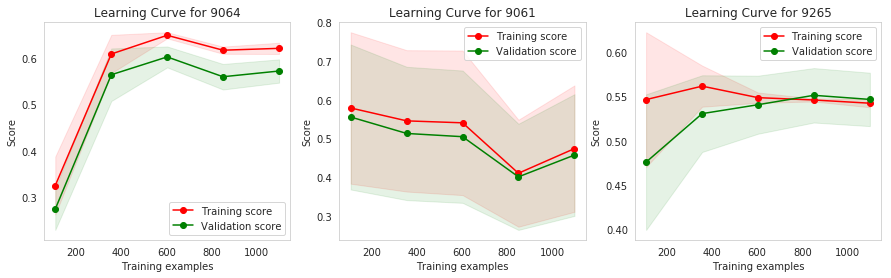

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit

f, ax = plt.subplots(1, 3, figsize=(15,4))
i = 0
for stock in stocks:
    log_clf = fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock)
    lob.plot_learning_curve(
        log_clf, d_stocks[stock][['prev_queue_imbalance', 'queue_imbalance']],
        d_stocks[stock]['mid_price_indicator'], 
        cv=TimeSeriesSplit(n_splits=10, max_train_size=9000), ax=ax[i], scoring='f1')
    ax[i].set_title('Learning Curve for {}'.format(stock))
    i += 1
if should_save_fig:
    plt.savefig('svm_learning_curves_prev_queue_imb.png')

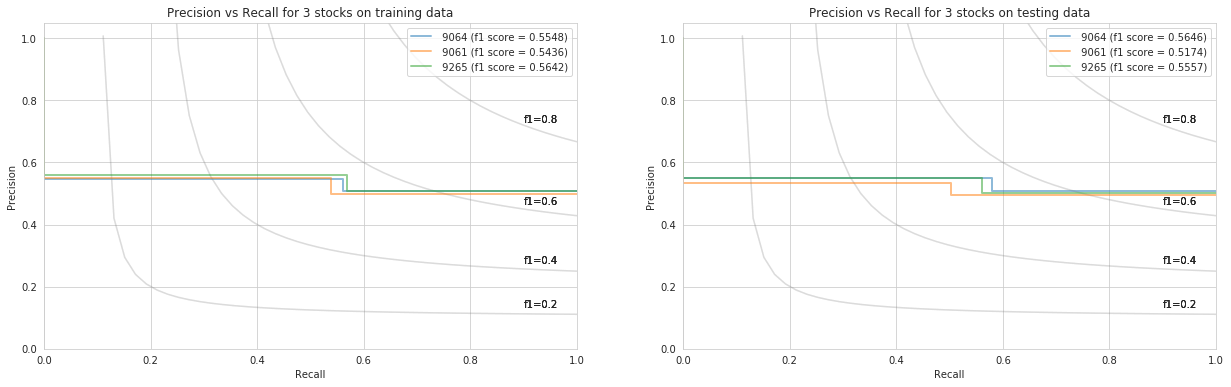

In [15]:
f, (ax1, ax3) = plt.subplots(1, 2, figsize=(21,6))
for stock in stocks:
    log_clf = fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock)
    pred_train = log_clf.predict(d_stocks[stock][['prev_queue_imbalance', 'queue_imbalance']])
    pred_test = log_clf.predict(d_test_stocks[stock][['prev_queue_imbalance', 'queue_imbalance']])
    d_stocks[stock]['pred_log'] = pred_train
    d_test_stocks[stock]['pred_log'] = pred_test
    lob.plot_f1(d_stocks[stock], log_clf, stock=stock, label='', ax=ax1,
                 title='Precision vs Recall for 3 stocks on training data', 
                features=['prev_queue_imbalance', 'queue_imbalance'])
    lob.plot_f1(d_test_stocks[stock], log_clf, stock=stock, label='', ax=ax3,
                 title='Precision vs Recall for 3 stocks on testing data', 
                features=['prev_queue_imbalance', 'queue_imbalance'])
if should_save_fig:
    plt.savefig('svm_results_prev_queue_imb.png')

In [17]:
def get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock):
    scores = {'stock': stock}
    for func_name, func in functions_to_run.items():
        for df_name, df in dfs.items():
            pred = log_clf.predict(df[['prev_queue_imbalance', 'queue_imbalance']])
            scores['{}_{}'.format(df_name, func_name)] = func(df['mid_price_indicator'], pred)
    return scores
            
functions_to_run = {'precision': metrics.precision_score, 'roc_auc': metrics.roc_auc_score,
                   'f1_score': metrics.f1_score, 'recall': metrics.recall_score,
                   'matthews': metrics.matthews_corrcoef, 'kappa': metrics.cohen_kappa_score}
scores = []
for stock in stocks:
    log_clf = fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock)
    dfs = {'train': d_stocks[stock], 'test': d_test_stocks[stock], }
    res_train = model.validate_model(fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock), 
                                     d_stocks[stock][['prev_queue_imbalance', 'queue_imbalance']], 
                                     d_stocks[stock]['mid_price_indicator'])
    res = get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock)
    res = {**res, **res_train}
    scores.append(res)
df_scores = pd.DataFrame(scores, index=stocks)

In [18]:
df_scores[['train_precision', 'precision', 'test_precision', 'train_recall', 'recall', 'test_recall']]

,train_precision,precision,test_precision,train_recall,recall,test_recall
9064,"[0.548431105047749, 0.5265454545454545, 0.5397...","[0.48342541436464087, 0.5612582781456954, 0.53...",0.550031,"[0.7115044247787611, 0.6611872146118721, 0.667...","[0.660377358490566, 0.5905923344947736, 0.5787...",0.579948
9061,"[0.5608465608465608, 0.5459016393442623, 0.543...","[0.47333333333333333, 0.5353159851301115, 0.63...",0.532338,"[0.5750452079566004, 0.32205029013539654, 0.29...","[0.5904365904365905, 0.2774566473988439, 0.247...",0.503360
9265,"[0.5505836575875487, 0.5517241379310345, 0.547...","[0.5544354838709677, 0.5379061371841155, 0.528...",0.549902,"[0.5349716446124764, 0.5486561631139945, 0.542...","[0.5, 0.5643939393939394, 0.5592592592592592, ...",0.561626


In [19]:
df_scores[['train_f1', 'f1', 'test_f1_score', 'train_roc_auc', 'roc_auc', 'test_roc_auc']]

,train_f1,f1,test_f1_score,train_roc_auc,roc_auc,test_roc_auc
9064,"[0.6194144838212634, 0.5862348178137652, 0.596...","[0.5582137161084529, 0.5755517826825127, 0.553...",0.564593,"[0.5405141171512853, 0.5305936073059361, 0.537...","[0.4962601078167116, 0.5385132215109527, 0.532...",0.544217
9061,"[0.567857142857143, 0.40510948905109495, 0.379...","[0.5254394079555966, 0.365482233502538, 0.3556...",0.517444,"[0.5556790285593058, 0.5401699967256389, 0.535...","[0.5357765875007254, 0.5292712308798072, 0.553...",0.533944
9265,"[0.5426653883029723, 0.550185873605948, 0.5445...","[0.5258126195028681, 0.5508317929759704, 0.543...",0.555702,"[0.5616034693650618, 0.555890297724118, 0.5542...","[0.5453703703703704, 0.5544389625795321, 0.535...",0.550506


In [ ]:
print(df_scores[['train_matthews', 'matthews', 'test_matthews', 
                 'train_roc_auc', 'roc_auc', 'test_roc_auc']].to_latex())

In [20]:
def convert_scores(df, column):
    scores = []
    for i, row in df.iterrows():
        scores.append(np.mean(row[column]))
    return scores
scores_columns = ['f1', 'kappa', 'matthews', 'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']

for col in scores_columns:
    df_scores[col] = convert_scores(df_scores, col)
df_scores

,f1,kappa,matthews,precision,recall,roc_auc,stock,test_f1_score,test_kappa,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_f1_score,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
9064,0.562504,0.073433,0.073605,0.542368,0.586930,0.536681,9064,0.564593,0.088520,0.088657,0.550031,0.579948,0.544217,0.579403,0.554779,0.074505,0.075727,0.542431,0.623595,0.537127
9061,0.475214,0.089765,0.096358,0.560022,0.439866,0.545096,9061,0.517444,0.067915,0.068015,0.532338,0.503360,0.533944,0.479880,0.543596,0.089854,0.093150,0.548362,0.436991,0.544608
9265,0.560341,0.103544,0.104259,0.560124,0.564276,0.551807,9265,0.555702,0.101014,0.101037,0.549902,0.561626,0.550506,0.555048,0.564207,0.107524,0.107560,0.551626,0.558653,0.553750


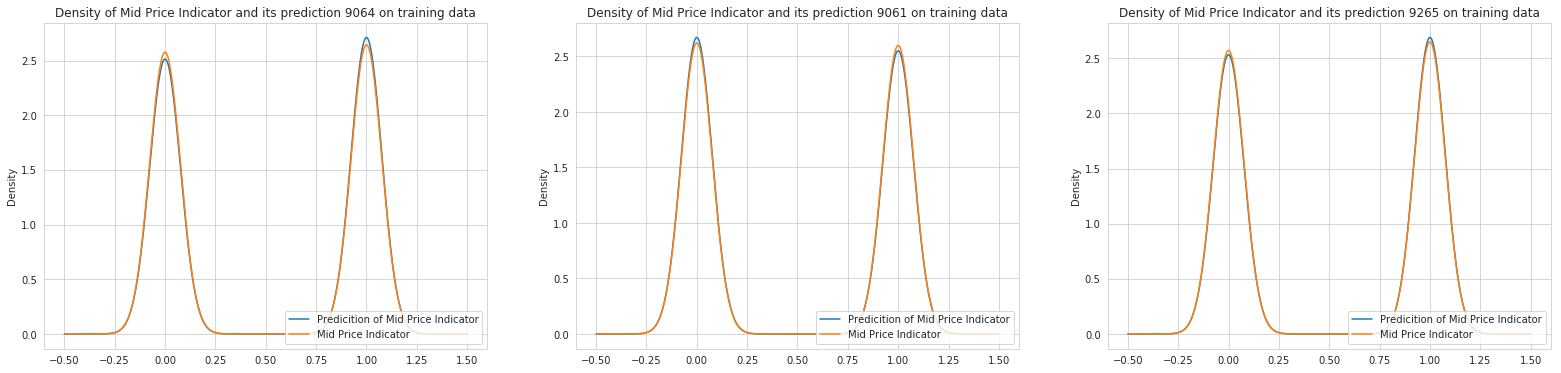

In [21]:
f, ax = plt.subplots(1, 3, figsize=(27,6))
for i in range(len(stocks)):
    s = stocks[i]
    d_stocks[s]['Predicition of Mid Price Indicator'] = d_stocks[s]['pred_log']
    d_stocks[s]['Mid Price Indicator'] = d_stocks[s]['mid_price_indicator']
    d_stocks[s][['Predicition of Mid Price Indicator', 'Mid Price Indicator']].plot(
        kind='kde', ax=ax[i])
    ax[i].set_title('Density of Mid Price Indicator and its prediction {} on training data'.format(s))
    ax[i].legend(loc='lower right')
if should_save_fig:
    plt.savefig('density_of_mid_price_and_prediction_training_data_svm_prev_queue_imb.png')

In [27]:
print(df_scores[['train_matthews', 'matthews', 'test_matthews', 
                 'train_roc_auc', 'roc_auc', 'test_roc_auc']].to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  train\_matthews &  matthews &  test\_matthews &  train\_roc\_auc &   roc\_auc &  test\_roc\_auc \\
\midrule
9064 &        0.075727 &  0.073605 &       0.088657 &       0.537127 &  0.536681 &      0.544217 \\
9061 &        0.093150 &  0.096358 &       0.068015 &       0.544608 &  0.545096 &      0.533944 \\
9265 &        0.107560 &  0.104259 &       0.101037 &       0.553750 &  0.551807 &      0.550506 \\
\bottomrule
\end{tabular}



Saving figure


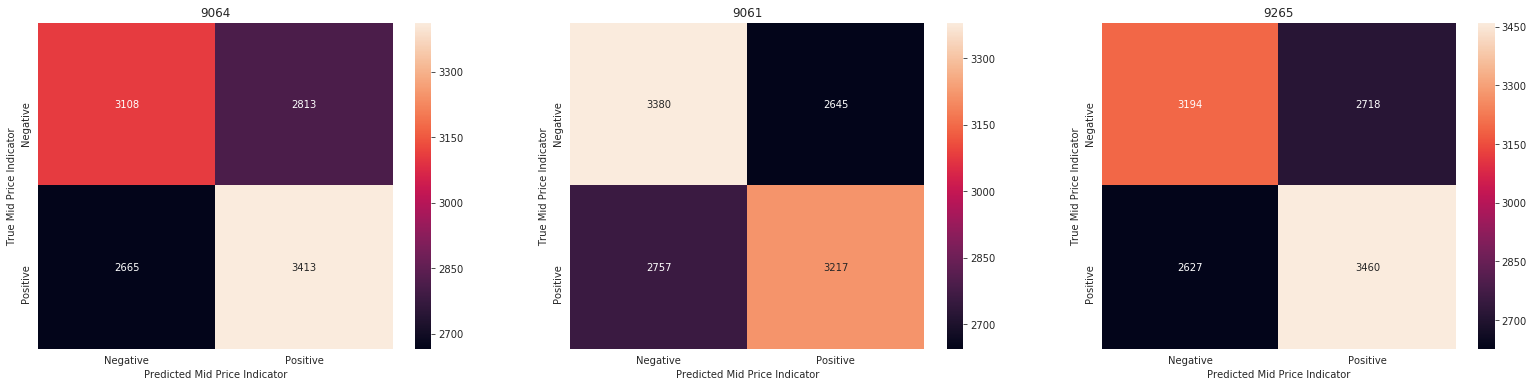

In [28]:
f, ax = plt.subplots(1, 3, figsize=(27,6))
for i in range(len(stocks)):
    stock = stocks[i]
    d_stocks[stock]['Predicition of Mid Price Indicator'] = d_stocks[stock]['pred_log']
    d_stocks[stock]['Mid Price Indicator'] = d_stocks[stock]['mid_price_indicator']
    sns.heatmap(metrics.confusion_matrix(d_stocks[stock]['mid_price_indicator'], d_stocks[stock]['pred_log']), 
               ax=ax[i], annot=True, fmt='d', xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    
    ax[i].set_title('{}'.format(stock))
    ax[i].set_ylabel('True Mid Price Indicator')
    ax[i].set_xlabel('Predicted Mid Price Indicator')
if should_save_fig:
    print('Saving figure')
    plt.savefig('svm_prev_imb_confusion_matrix.png')

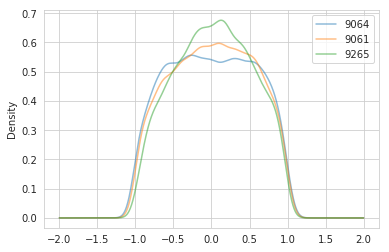

In [23]:
for s in stocks:
   # plt.figure()
    d_stocks[s]['queue_imbalance'].plot(kind='kde', label=s, alpha=0.5)
   # d_stocks[s]['mid_price_indicator'].plot(kind='kde', label=s)
    plt.legend()

(Unnamed: 0                            6087
 bid                                   6087
 ask                                   6087
 bid_price                             6087
 ask_price                             6087
 mid_price                             6087
 sum_sell_ask                          6087
 sum_buy_bid                           6087
 mid_price_indicator                   6087
 queue_imbalance                       6087
 prev_queue_imbalance                  6087
 pred_log                              6087
 Predicition of Mid Price Indicator    6087
 Mid Price Indicator                   6087
 dtype: int64, Unnamed: 0                            5912
 bid                                   5912
 ask                                   5912
 bid_price                             5912
 ask_price                             5912
 mid_price                             5912
 sum_sell_ask                          5912
 sum_buy_bid                           5912
 mid_price_indicat

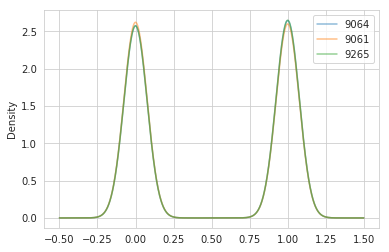

In [24]:
for s in stocks:
   # plt.figure()
   # d_stocks[s]['queue_imbalance'].plot(kind='kde', label=s, alpha=0.5)
    d_stocks[s]['mid_price_indicator'].plot(kind='kde', label=s, alpha=0.5)
    plt.legend()
s = stocks[2]
d_stocks[s][d_stocks[s]['mid_price_indicator'] == 1].count(), d_stocks[s][d_stocks[s]['mid_price_indicator'] == 0].count()

In [25]:
df_best_svm

,Unnamed: 0,c,coef0,f1,features,gamma,kappa,matthews,method,precision,recall,roc_auc,stock,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
308,308.0,10.0,NaN,0.570805,"queue_imbalance, prev_queue_imbalance",0.10,0.093442,0.094258,svm_rbf,0.549325,0.596207,0.546747,9064,0.573081,0.086055,0.086759,0.548268,0.601939,0.542950
308,308.0,10.0,NaN,0.474580,"queue_imbalance, prev_queue_imbalance",0.10,0.094421,0.100853,svm_rbf,0.567493,0.431431,0.547208,9061,0.469295,0.088058,0.092412,0.547479,0.424161,0.543581
34,34.0,100.0,0.1,0.556714,"queue_imbalance, prev_queue_imbalance",0.01,0.103384,0.103937,svm_sigmoid,0.561512,0.554829,0.551669,9265,0.554006,0.104833,0.104861,0.550771,0.557389,0.552403


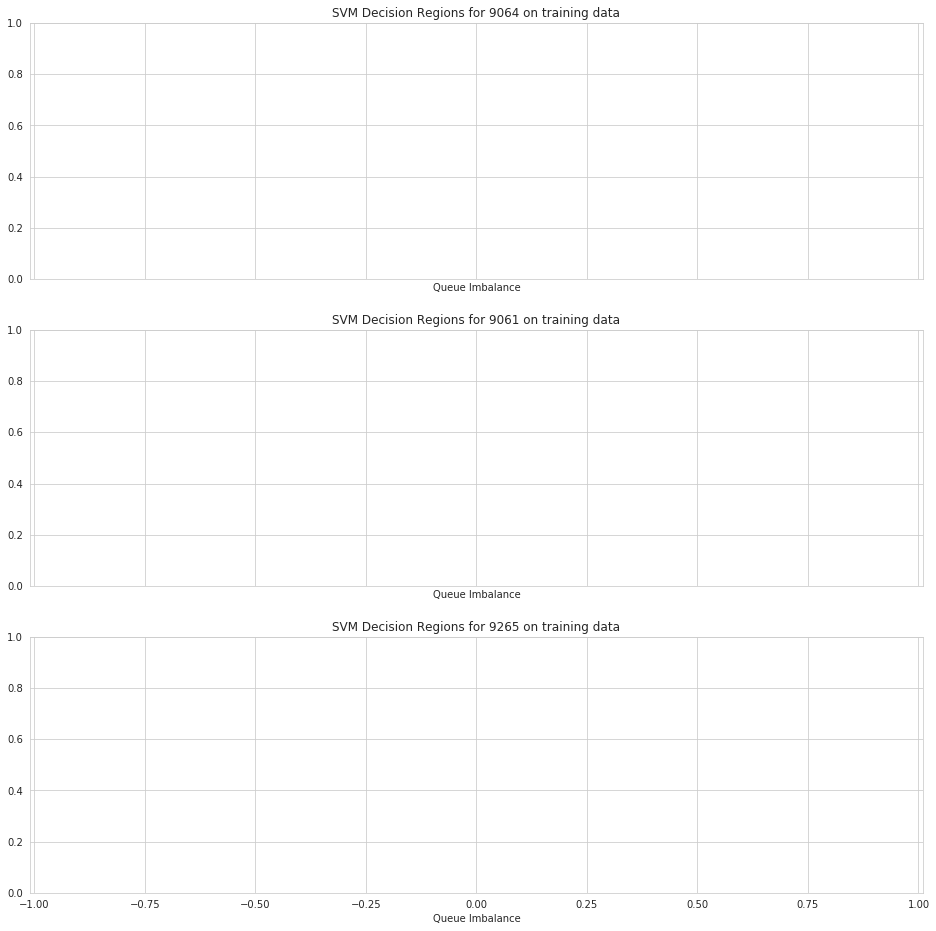

In [26]:
f, ax = plt.subplots(3, 1, figsize=(16, 16), sharex=True)
i = 0

for i in range(len(stocks)):
    s = stocks[i]
    df = d_stocks[s]
    X = d_stocks[s][['prev_queue_imbalance', 'queue_imbalance']].values
    y = d_stocks[s]['mid_price_indicator'].values.astype(np.integer)

    clf = fit_best_svm_classifier(df_best_svm, d_stocks[s], stock=s)
    # plot_decision_regions(X[0:1500], y[0:1500], clf=clf,ax=ax[i], colors=','.join(['orange', 'blue']))
    ax[i].set_xlabel('Previous Queue Imbalance')
    ax[i].set_xlabel('Queue Imbalance')
    ax[i].set_title('SVM Decision Regions for {} on training data'.format(s))
    ax[i].set_xlim(-1.01, 1.01)

if should_save_fig:
    plt.savefig('svm_decision_region_prev_queue_imb.png')